# 11.1. Urban planning multi-stakeholder problem

Python code for the urban planning multi-stakeholder design problem.
Python code for the shopping mall design problem revisited non-linear example ([Chapter 7.2](https://teachbooks.github.io/systems-engineering-design/main/chapters/chapter_7_2.html)).

```{note}
Press the rocket symbol on the top right of the page to make the page interactive and play with the code! 
```

## Import Packages

This script is fairly similar to the non-linear shopping mall example. Only the preference functions for objective 1 and 2 are changed, together with the weights.

Note that the non-linear preference curves are created by using an interpolation function called pchip_interpolation.


In [1]:
# !pip install micropip
# !pip install requests
# !pip install urllib3

In [2]:
# import micropip
# await micropip.install("urllib3 ")
# await micropip.install("requests")

import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate

from genetic_algorithm_pfm import GeneticAlgorithm

## Set Weights for Different Objectives

Set weights for the different objectives.

In [3]:
w1 = .50 # Project developer
w2 = .50 # Municipality

def objective_p1(x1, x2, x3, x4):
    """
    Objective to maximize the profit.

    :param x1: 1st design variable
    :param x2: 2nd design variable
    :param x3: 3rd design variable
    :param x4: 4th design variable
    :param x5: 5th design variable
    :param x6: 6th design variable
    """
    return pchip_interpolate([3000, 3500, 4000], [0, 20, 100], (11.25 * x1 + 13.75 * x2 + 15 * x3 + 11.25 * x4))


def objective_p2(x1, x2, x3, x4):
    """
    Objective to maximize the amount of affordable houses.

    :param x1: 1st design variable
    :param x2: 2nd design variable
    :param x3: 3rd design variable
    :param x4: 4th design variable
    :param x5: 5th design variable
    :param x6: 6th design variable
    """
    return pchip_interpolate([100, 125, 160], [0, 50, 100], (x1 + x4))

def objective(variables):
    """
    Objective function that is fed to the GA. Calles the separate preference functions that are declared above.

    :param variables: array with design variable values per member of the population. Can be split by using array
    slicing
    :return: 1D-array with aggregated preference scores for the members of the population.
    """
    # extract 1D design variable arrays from full 'variables' array
    x1 = variables[:, 0]
    x2 = variables[:, 1]
    x3 = variables[:, 2]
    x4 = variables[:, 3]

    # calculate the preference scores
    p_1 = objective_p1(x1, x2, x3, x4)
    p_2 = objective_p2(x1, x2, x3, x4)

    # aggregate preference scores and return this to the GA
    return [w1, w2], [p_1, p_2]

## Define Constraints and Bounds
Before we can run the optimization, we finally need to define the constraints and bounds.

In [4]:
def constraint_1(variables):
    """Constraint that at least 200 houses need to be built.

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: list with scores of the constraint
    """
    x1 = variables[:, 0]
    x2 = variables[:, 1]
    x3 = variables[:, 2]
    x4 = variables[:, 3]

    return -(x1 + x2 + x3 + x4) + 200  # < 0


def constraint_2(variables):
    """Constraint that no more than 260 can be built.

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: list with scores of the constraint
    """
    x1 = variables[:, 0]
    x2 = variables[:, 1]
    x3 = variables[:, 2]
    x4 = variables[:, 3]

    return x1 + x2 + x3 + x4 - 260  # < 0

def constraint_3(variables):
    """Constraint that the profit cannot be lower than where the preference function intersects the x-axis.

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: list with scores of the constraint
    """
    x1 = variables[:, 0]
    x2 = variables[:, 1]
    x3 = variables[:, 2]
    x4 = variables[:, 3]

    return -(11.25 * x1 + 13.75 * x2 + 15 * x3 + 11.25 * x4) + 3000  # < 0

def constraint_4(variables):
    """Constraint that the number of affordable houses cannot be lower than where the preference function intersects the x-axis.

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: list with scores of the constraint
    """
    x1 = variables[:, 0]
    x2 = variables[:, 1]
    x3 = variables[:, 2]
    x4 = variables[:, 3]

    return -(x1 + x4) + 100  # < 0

def constraint_5(variables):
    """Constraint that the profit cannot be higher than were the preference function is at 100.

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: list with scores of the constraint
    """
    x1 = variables[:, 0]
    x2 = variables[:, 1]
    x3 = variables[:, 2]
    x4 = variables[:, 3]

    return 11.25 * x1 + 13.75 * x2 + 15 * x3 + 11.25 * x4 - 4000  # < 0

def constraint_6(variables):
    """Constraint that the number of affordable houses cannot be higher than where the preference function is at 100.

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: list with scores of the constraint
    """
    x1 = variables[:, 0]
    x2 = variables[:, 1]
    x3 = variables[:, 2]
    x4 = variables[:, 3]

    return x1 + x4 - 150  # < 0

# define list with constraints
cons = [['ineq', constraint_1], ['ineq', constraint_2], ['ineq', constraint_3], ['ineq', constraint_4], ['ineq', constraint_5], ['ineq', constraint_6]]

# set bounds for all variables
b1 = [0, 260]  # x1
b2 = [0, 260]  # x2
b3 = [0, 260]  # x3
b4 = [0, 260]  # x4
bounds = [b1, b2, b3, b4]

## Graphical Output
Setup the graphical output.

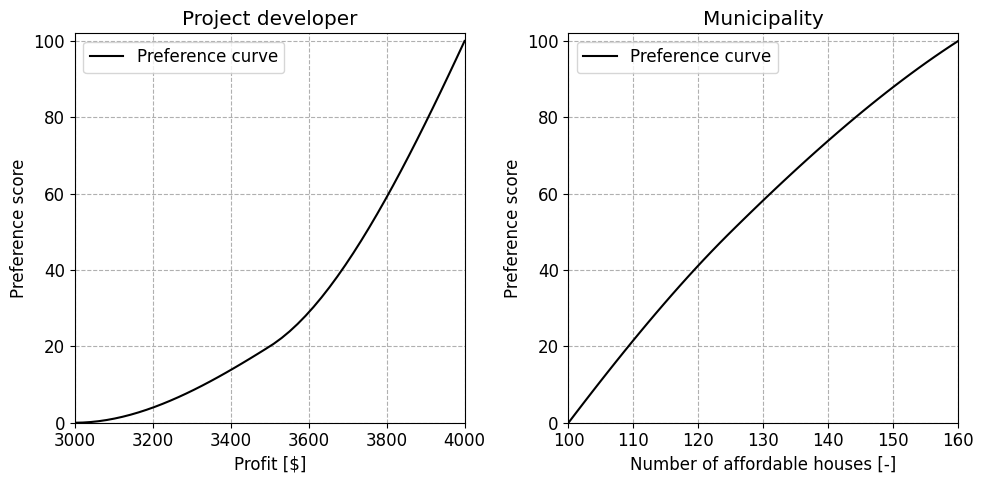

In [5]:
# create arrays for plotting continuous preference curves
c1 = np.linspace(3000, 4000)
c2 = np.linspace(100, 160)

# calculate the preference functions
p1 = pchip_interpolate([3000, 3500, 4000], [0, 20, 100], (c1))
p2 = pchip_interpolate([100, 125, 160], [0, 50, 100], (c2))

# create figure that plots all preference curves and the preference scores of the returned results of the GA
fig = plt.figure(figsize=((10,5)))

font1 = {'size':20}
font2 = {'size':15}

plt.rcParams['font.size'] = '12'
plt.rcParams['savefig.dpi'] = 300

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(c1, p1, label='Preference curve', color='black')

ax1.set_xlim((3000, 4000))
ax1.set_ylim((0, 102))
ax1.set_title('Project developer')
ax1.set_xlabel('Profit [$]')
ax1.set_ylabel('Preference score')
ax1.grid()
ax1.grid(linestyle = '--')

#fig = plt.figure()
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(c2, p2, label='Preference curve', color='black')
ax2.set_xlim((100, 160))
ax2.set_ylim((0, 102))
ax2.set_title('Municipality')
ax2.set_xlabel('Number of affordable houses [-]')
ax2.set_ylabel('Preference score')
ax2.grid()
ax2.legend()
ax2.grid(linestyle = '--')

ax1.legend()
ax2.legend()
fig.tight_layout()

#Two  lines to make our compiler able to draw:
#fig.savefig("/home/ruud/engineeringdesign.education/static/urbanplanningproblemfunctions.png")

## Optimization

Now we have everything for the optimization, we can run it. For more information about the different options to 
configure the GA, see the docstring of GeneticAlgorithm (via help()) or chapter 4 of the reader.
Once we have the results, we can make some figures. First, the resulting design variables are plotted into the solution space. Secondly, we can plot the preference functions together with the results of the optimizations.

Run GA with minmax
The type of aggregation is set to minmax
Generation   Best score   Mean             Max stall    Diversity    Number of non-feasible results
0            45.2526      470333333.4238   0            0.009        499         
1            44.9155      217666676.9579   0            0.092        388         
2            40.5756      139666689.988    0            0.106        243         
3            40.5756      125333355.9929   1            0.246        232         
4            40.5756      110000024.3778   2            0.245        210         
5            40.5756      95000025.8846    3            0.239        193         
6            40.5756      104333358.4964   4            0.246        200         
7            40.5756      89666692.8365    5            0.244        187         
4            40.5756      110000024.3778   2            0.245        210         
5            40.5756      95000025.8846    3            0.239        193         
6            40.5756

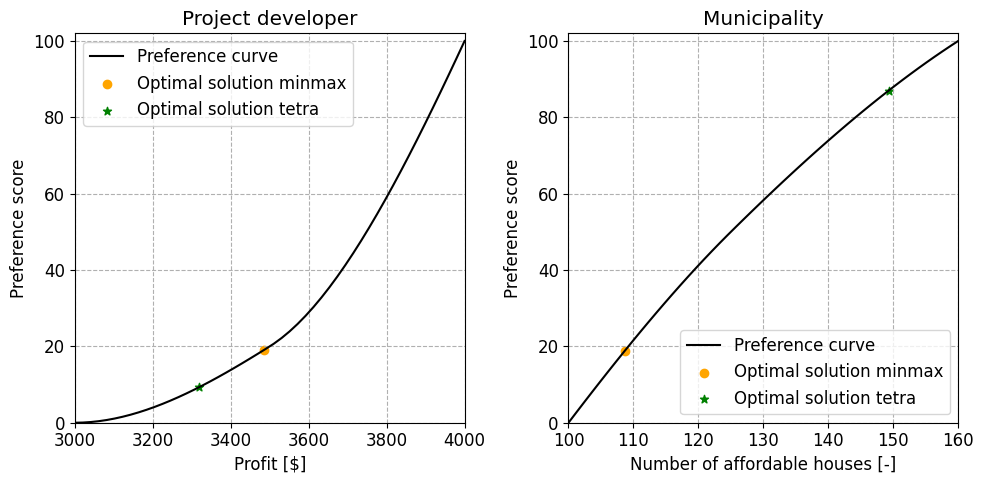

In [6]:
# Set random seed for reproducibility
np.random.seed(42)

# We run the optimization with two paradigms
paradigm = ['minmax', 'tetra']
marker = ['o', '*']
colours = ['orange','green']

# The figure and axes are defined before the loop
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for i in range(2):
    # make dictionary with parameter settings for the GA run with the IMAP solver
    options = {
        'n_bits': 8,
        'n_iter': 400,
        'n_pop': 500,
        'r_cross': 0.8,
        'max_stall': 8,  # Back to original value to match API
        'aggregation': paradigm[i], # minmax or tetra
        'var_type': 'real'
    }

    # run the GA and print its result
    print(f'Run GA with ' + paradigm[i])
    ga = GeneticAlgorithm(objective=objective, constraints=cons, bounds=bounds, options=options)
    score_IMAP, design_variables_IMAP, _ = ga.run()

    print(f'Optimal result for x1 = {round(design_variables_IMAP[0], 2)} houses and '
          f'x2 = {round(design_variables_IMAP[1], 2)} houses and '
          f'x3 = {round(design_variables_IMAP[2], 2)} houses and '
          f'x4 = {round(design_variables_IMAP[3], 2)} houses')

    profit = round(11.25*design_variables_IMAP[0]+13.75*design_variables_IMAP[1]+15*design_variables_IMAP[2]+11.25*design_variables_IMAP[3])
    print(f'Profit: {profit}')

    # Calculate individual preference scores for the GA results
    c1_res = (11.25*design_variables_IMAP[0]+13.75*design_variables_IMAP[1]+15*design_variables_IMAP[2]+11.25*design_variables_IMAP[3])
    p1_res = pchip_interpolate([3000, 3500, 4000], [0, 20, 100], (c1_res))

    c2_res = (design_variables_IMAP[0]+design_variables_IMAP[3])
    p2_res = pchip_interpolate([100, 125, 160], [0, 50, 100], (c2_res))

    # Debugging prints to check the calculated values
    print(f"c1_res: {c1_res}, p1_res: {p1_res}")
    print(f"c2_res: {c2_res}, p2_res: {p2_res}")

    # Plot the preference curves
    if i == 0:  # Only plot curves once
        c1 = np.linspace(3000, 4000)
        c2 = np.linspace(100, 160)

        p1 = pchip_interpolate([3000, 3500, 4000], [0, 20, 100], c1)
        p2 = pchip_interpolate([100, 125, 160], [0, 50, 100], c2)

        ax1.plot(c1, p1, label='Preference curve', color='black')
        ax1.set_xlim((3000, 4000))
        ax1.set_ylim((0, 102))
        ax1.set_title('Project developer')
        ax1.set_xlabel('Profit [$]')
        ax1.set_ylabel('Preference score')
        ax1.grid(linestyle='--')

        ax2.plot(c2, p2, label='Preference curve', color='black')
        ax2.set_xlim((100, 160))
        ax2.set_ylim((0, 102))
        ax2.set_title('Municipality')
        ax2.set_xlabel('Number of affordable houses [-]')
        ax2.set_ylabel('Preference score')
        ax2.grid(linestyle='--')

    # Scatter the results on the preference curve plots
    ax1.scatter(c1_res, p1_res, label='Optimal solution ' + paradigm[i], color= colours[i], marker=marker[i])
    ax2.scatter(c2_res, p2_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])

# Add legends and adjust layout after plotting all data points
ax1.legend()
ax2.legend()
fig.tight_layout()

# Display the plot
plt.show()
